In [1]:
import os
import pickle
import cv2
import matplotlib.pyplot as plt
import warnings
import shutil

warnings.filterwarnings(action='ignore')

In [2]:
image_dir = 'poster/daum/'
genre_dir = 'poster/daum.txt'

genres_dict = pickle.load(open(genre_dir, 'rb'))
sample_img_dir = image_dir+'242.jpg'
sample_genre = genres_dict[242]
sample_img_dir,sample_genre

('poster/daum/242.jpg', ['드라마'])

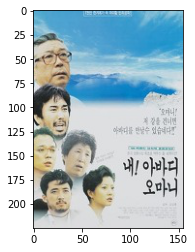

['드라마']
(225, 155, 3)


In [3]:
_ = plt.imread(sample_img_dir)
plt.imshow(_)
plt.show()
print(sample_genre)
print(_.shape)

In [4]:
from collections import Counter 

n_genres = {item:0 for i in genres_dict.values() for item in i}
for key in genres_dict:
    values = genres_dict[key]
    for item in values:
        n_genres[item]+=1

In [5]:
from collections import Counter 
k = Counter(n_genres) 
high = k.most_common()
high

[('드라마', 1415),
 ('코미디', 713),
 ('로맨스', 624),
 ('멜로', 624),
 ('액션', 578),
 ('스릴러', 353),
 ('범죄', 200),
 ('공포', 170),
 ('SF', 160),
 ('어드벤처', 158),
 ('애니메이션', 143),
 ('판타지', 137),
 ('미스터리', 106),
 ('전쟁', 102),
 ('시대극', 88),
 ('가족', 68),
 ('성인', 68),
 ('다큐멘터리', 54),
 ('뮤지컬', 41),
 ('무협', 18),
 ('서부', 18),
 ('한국', 11),
 ('프랑스', 3),
 ('미국', 2),
 ('대만', 2),
 ('독일', 2),
 ('스페인', 1),
 ('캐나다', 1),
 ('영국', 1),
 ('헝가리', 1),
 ('노르웨이', 1),
 ('네덜란드', 1),
 ('스웨덴', 1),
 ('브라질', 1),
 ('오스트레일리아', 1),
 ('핀란드', 1),
 ('프랑스, 스위스, 이탈리아', 1),
 ('러시아', 1)]

In [6]:
except_genre = [i[0] for i in high[21:]]
except_genre

['한국',
 '프랑스',
 '미국',
 '대만',
 '독일',
 '스페인',
 '캐나다',
 '영국',
 '헝가리',
 '노르웨이',
 '네덜란드',
 '스웨덴',
 '브라질',
 '오스트레일리아',
 '핀란드',
 '프랑스, 스위스, 이탈리아',
 '러시아']

In [7]:
## 국가 데이터가 있음
## 한국~러시아 데이터는 제외
## 만약 국가 데이터만 가지고있는 데이터라면, 삭제
new_genres_dict = {}

for key in genres_dict:
    temp=[]
    for genre in genres_dict[key]:
        if genre in except_genre:
            continue
        temp.append(genre)
        
    if len(temp)==0:
        continue
    try:
        shutil.copy(image_dir+f'{key}.jpg', 'poster/excepted_daum/'+f'{key}.jpg')
    except FileNotFoundError:
        continue
    new_genres_dict[key]=temp

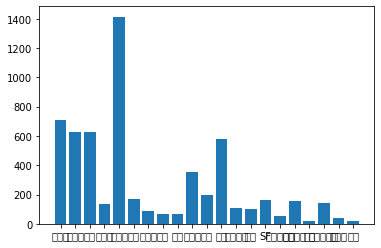

In [8]:
n_genres = {item:0 for i in new_genres_dict.values() for item in i}
for key in new_genres_dict:
    values = new_genres_dict[key]
    for item in values:
        n_genres[item]+=1
plt.bar(range(len(n_genres)), list(n_genres.values()), align='center')
plt.xticks(range(len(n_genres)), list(n_genres.keys()))
plt.show()

In [9]:
from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader

import torchvision
from torchvision import transforms,datasets

In [10]:
class CustomDataset(Dataset):
    def __init__(self,transform):
        self.imgs_dir = 'poster/excepted_daum/'
        self.transform = transform
        self.image_list = os.listdir(self.imgs_dir)
        
        self.labels = new_genres_dict
        self.label_list = list({item for i in self.labels.values() for item in i})
        self.num_label = len(self.label_list)
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self,idx):
        img_dir = str(list(self.labels.keys())[idx])+'.jpg'
        image = Image.open(os.path.join(self.imgs_dir, img_dir))
        image.convert('RGB')
        x = self.transform(image)
        if x.size(0)==4:x=x[:-1,:,:]
        if x.size(0)==1:x=x.expand(3,-1,-1)
        labels = self.labels[int(img_dir.split('.')[0])]
        labels_encoding = [self.label_list.index(i) for i in labels]
        y = torch.zeros(self.num_label)
        y[labels_encoding]=1
        return x,y

In [11]:
mytransform=transforms.Compose([transforms.Resize((128,128)),
                                transforms.RandomRotation(45),
                                transforms.RandomAffine(30),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                transforms.ToTensor()])

In [12]:
dset = CustomDataset(mytransform)
dset[0][0].size(),dset[0][1]

(torch.Size([3, 128, 128]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]))

In [13]:
ratio = [int(len(dset)*0.8),len(dset)-int(len(dset)*0.8)]
trainset, valset = torch.utils.data.random_split(dset,ratio)

In [14]:
def create_head(num_features , number_classes ,dropout_prob=0.5 ,activation_func =nn.ReLU):
    features_lst = [num_features , num_features//2 , num_features//4]
    layers = []
    for in_f ,out_f in zip(features_lst[:-1] , features_lst[1:]):
        layers.append(nn.Linear(in_f , out_f))
        layers.append(activation_func())
        layers.append(nn.BatchNorm1d(out_f))
        if dropout_prob !=0 : layers.append(nn.Dropout(dropout_prob))
    layers.append(nn.Linear(features_lst[-1] , number_classes))
    return nn.Sequential(*layers)

In [15]:
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import f1_score
import numpy as np

In [16]:
res_model = torchvision.models.resnet152(pretrained=True) # load the pretrained model
num_features = res_model.fc.in_features # get the no of on_features in last Linear unit
for param in res_model.parameters():
    param.requires_grad_(False)
top_head = create_head(num_features , 21)
res_model.fc = top_head # replace the fully connected layer

In [17]:
def select_optimizer(model, args):
    lr = args['lr']
    betas = args['betas']
    eps = args['eps']
    weight_decay = args['weight_decay']
    amsgrad = args['amsgrad']
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas , 
                                 eps=eps,weight_decay=weight_decay,
                                amsgrad=amsgrad)
    return optimizer

def select_scheduler(optimizer, config):
    T_max = config['T_max']
    verbose = config['verbose']

    scheduler = CosineAnnealingLR(optimizer,T_max=T_max,verbose=verbose)
    return scheduler

def f1_score_(pred, target, threshold=0.2):
    pred = np.array(pred.cpu() > threshold, dtype=float)
    return f1_score(target.cpu(), pred, average='micro')

In [18]:
batch_size = 256
optim_args = {'lr':0.01,'betas':(0.9,0.999),'eps':1e-08,'weight_decay':0,'amsgrad':False}
sche_args = {'T_max':100,'verbose':True}

In [19]:
train_dataloader = DataLoader(trainset,batch_size=batch_size,
                        shuffle=True,num_workers=4,
                        drop_last=True,pin_memory=True)

val_dataloader = DataLoader(valset,batch_size=batch_size,num_workers=4)

In [20]:
res_model.cuda()
optimizer = select_optimizer(res_model,optim_args)
scheduler = select_scheduler(optimizer, sche_args)
criterion = nn.BCEWithLogitsLoss()

Adjusting learning rate of group 0 to 1.0000e-02.


In [21]:
def get_best_model(model, dset, batch_size, optim_args, sche_args):
    trainset, valset = torch.utils.data.random_split(dset,ratio)
    train_dataloader = DataLoader(trainset,batch_size=batch_size,
                        shuffle=True,num_workers=4,
                        drop_last=True,pin_memory=True)

    val_dataloader = DataLoader(valset,batch_size=batch_size,num_workers=4)
    
    res_model.cuda()
    optimizer = select_optimizer(res_model,optim_args)
    scheduler = select_scheduler(optimizer, sche_args)
    criterion = nn.BCEWithLogitsLoss()
    
    
    best_epoch = 0
    best_loss = 9999
    for epoch in range(sche_args['T_max']):
        model.train()
        train_losses = []
        train_measure = 0
        train_cnt = 0
        for idx,data in enumerate(train_dataloader):
            x,y = data
            x,y = x.cuda(),y.cuda()
            optimizer.zero_grad()
            y_pred = res_model(x)

            loss = criterion(y_pred,y)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.detach())
            train_measure += f1_score_(torch.sigmoid(y_pred), y, threshold=0.25) * batch_size
            train_cnt += batch_size

        res_model.eval()
        val_losses = []
        val_measure = 0
        val_cnt = 0
        for idx,data in enumerate(val_dataloader):
            x,y = data
            x,y = x.cuda(),y.cuda()
            y_pred = res_model(x)
            loss = criterion(y_pred,y)
            val_losses.append(loss.detach())
            val_measure += f1_score_(torch.sigmoid(y_pred), y, threshold=0.25)
            val_cnt += 1
        scheduler.step()
        if sum(val_losses)/len(val_losses) < best_loss:
            best_loss=sum(val_losses)/len(val_losses)
            best_epoch=epoch
    print(f'best loss = {best_loss} at {best_epoch+1} epoch')
    return model

In [22]:
import random

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(42)
random.seed(42)

In [23]:
res_model = torchvision.models.resnet152(pretrained=True) # load the pretrained model
num_features = res_model.fc.in_features # get the no of on_features in last Linear unit
for param in res_model.parameters():
    param.requires_grad_(False)
top_head = create_head(num_features , 21)
res_model.fc = top_head # replace the fully connected layer


for batch_size_ in [2048]:
    for lr_ in [0.05,0.01,0.005]:
        for betas1_ in [0.8,0.9,0.99]:
            for betas2_ in [0.9,0.95,0.999]:
                for eps_ in [1e-07,1e-08,1e-09]:
                    for wd_ in [0.001,0.0001,0]:
                        optim_args = {'lr':lr_,'betas':(betas1_,betas2_),'eps':eps_,'weight_decay':wd_,'amsgrad':True}
                        sche_args = {'T_max':150,'verbose':False}
                        print(batch_size_,optim_args)
                        get_best_model(res_model,dset,batch_size_,optim_args,sche_args)
                        print('------'*10)

1024 {'lr': 0.05, 'betas': (0.8, 0.95), 'eps': 1e-07, 'weight_decay': 0.001, 'amsgrad': True}
best loss = 0.208589568734169 at 148 epoch
------------------------------------------------------------
1024 {'lr': 0.05, 'betas': (0.8, 0.95), 'eps': 1e-08, 'weight_decay': 0.001, 'amsgrad': True}
best loss = 0.20836812257766724 at 149 epoch
------------------------------------------------------------
1024 {'lr': 0.05, 'betas': (0.8, 0.95), 'eps': 1e-09, 'weight_decay': 0.001, 'amsgrad': True}
best loss = 0.2137778103351593 at 139 epoch
------------------------------------------------------------
1024 {'lr': 0.05, 'betas': (0.8, 0.999), 'eps': 1e-07, 'weight_decay': 0.001, 'amsgrad': True}
best loss = 0.20698192715644836 at 149 epoch
------------------------------------------------------------
1024 {'lr': 0.05, 'betas': (0.8, 0.999), 'eps': 1e-08, 'weight_decay': 0.001, 'amsgrad': True}
best loss = 0.21061858534812927 at 149 epoch
------------------------------------------------------------
1

KeyboardInterrupt: 